# CMIP6 access and processing at DKRZ

In this notebook, we show how to access CMIP6 data at the DKRZ filesystem using the Intake catalog and xarray. To lift the heavy datasets we will process in parallel with dask using the power of the mistral supercomputer. This notebook is loosely based on the [CMIP6 global temperature pangeo example](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html).

import all neccessary modules here:

In [1]:
import dask
import fsspec
import intake
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import progress
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dask.__version__

<ipython-input-1-bed32f30e077>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'2021.04.0'

## Data access

We use `dask.distributed` to parallelize file access and processing. This will speed up our computations...

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

In [3]:
# client = Client(n_workers=24, threads_per_worker=2)
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39964 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 248.44 GiB


If you click on the dashboard link, you will see the dask workers in action!

We don't want to access single files or look for input data manually by browsing through the DKRZ filesystem. Instead we use a catalog, that DKRZ provides for looking up and accessing CMIP6 datasets.

In [4]:
import intake

%matplotlib
url = "/work/ik1017/Catalogs/mistral-cmip6.json"
pangeo_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(url)
cat

Using matplotlib backend: agg


,unique
activity_id,19
institution_id,39
source_id,101
experiment_id,210
member_id,447
table_id,38
variable_id,1162
grid_label,12
dcpp_init_year,61
version,653


The catalog is build around a pandas dataframe. We can also access it to explore the available data, e.g., 

In [5]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c2h6,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
1,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h6,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
2,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h8,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
3,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,cdnc,gn,NaN,v20200522,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
4,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,ch3coch3,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...


The catalog is actually build around a huge dataframe (or csv file) that contains a row for each netcdf file at DKRZ's CMIP6 pool. The row contains the filename including the path (`path` column) and several other CMIP related attributes that describe the content of the file. The catalog uses this table to search and filter for data and we don't even have to know where the file is exactly located! This would be nearly impossible to do by hand as you can see that the complete `CMIP6` catalog contains more than **5 million NetCDF files!**

We can also access the table using typical pandas data exploration techniques, e.g.,

In [6]:
cat.df.activity_id.unique()

array(['AerChemMIP', 'C4MIP', 'CDRMIP', 'CFMIP', 'CMIP', 'DAMIP', 'DCPP',
       'FAFMIP', 'GMMIP', 'GeoMIP', 'HighResMIP', 'ISMIP6', 'LS3MIP',
       'LUMIP', 'OMIP', 'PAMIP', 'PMIP', 'RFMIP', 'ScenarioMIP'],
      dtype=object)

This shows all available activity ids. We only want to access data concerning the `CMIP` and `ScenarioMIP` activities. Let's reduce our search results:

In [7]:
cmip6 = cat.search(activity_id=["CMIP", "ScenarioMIP"])
cmip6

,unique
activity_id,2
institution_id,33
source_id,67
experiment_id,19
member_id,220
table_id,38
variable_id,1126
grid_label,11
dcpp_init_year,0
version,557


That's still a lot of data (although, we almost reduced by half). Let's check out all available experiment ids that are available:

In [8]:
cmip6.df.experiment_id.unique()

array(['1pctCO2', 'abrupt-4xCO2', 'amip', 'historical', 'piControl',
       'esm-hist', 'esm-piControl', 'ssp126', 'ssp245', 'ssp370',
       'ssp585', 'esm-piControl-spinup', 'piControl-spinup', 'hist-GHG',
       'hist-nat', 'ssp119', 'ssp434', 'ssp460', 'ssp534-over'],
      dtype=object)

Let's concentrate on the usual suspects. We will furter reduce our catalog to use only the `historical` and common `ssp` scenarios. Here, we also reduce our catalog to monthly output of the surface temperature `tas` and the `r1i1p1f1` member id.

In [9]:
expts = ["historical", "ssp126", "ssp245", "ssp585"]
attributes = {
    "variable_id": "tas",
    "table_id": "Amon",
    "member_id": "r1i1p1f1",
    "experiment_id": expts,
}
subset = cmip6.search(**attributes, require_all_on="source_id")
subset

,unique
activity_id,2
institution_id,24
source_id,30
experiment_id,4
member_id,1
table_id,1
variable_id,1
grid_label,3
dcpp_init_year,0
version,56


As you can see, we have reduced our initial search of more than 5 million files to only 1652 that are of interest to us. Let again use the pandas dataframe to explore what we got, e.g.,

In [10]:
subset.df.groupby("source_id")[["experiment_id", "member_id"]].nunique()

,experiment_id,member_id
source_id,,
ACCESS-CM2,4,1
ACCESS-ESM1-5,4,1
AWI-CM-1-1-MR,4,1
BCC-CSM2-MR,4,1
CAMS-CSM1-0,4,1
CIESM,4,1
CMCC-CM2-SR5,4,1
CMCC-ESM2,4,1
CanESM5,4,1


Ok, we have now all `tas` datasets from all CMIP6 models for the historical period and three scenario experiments filtered out. Now, it's the time to actually look at the data. Let's open the datasets using the `to_dataset_dict` function that is built into the `intake-esm` catalog:

In [11]:
dsets = subset.to_dataset_dict(cdf_kwargs={"use_cftime": True, "chunks": {}})
# dsets = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Wow, that was fast! Just under a minute to open 120 datasets (30 models, 4 experiments). Let's have a look into the dataset keys:

In [12]:
dsets.keys()

dict_keys(['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.Amon.gn', 'ScenarioMIP.INM.INM-CM4-8.ssp126.Amon.gr1', 'ScenarioMIP.NUIST.NESM3.ssp126.Amon.gn', 'ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.Amon.gn', 'ScenarioMIP.KIOST.KIOST-ESM.ssp585.Amon.gr1', 'ScenarioMIP.CMCC.CMCC-ESM2.ssp585.Amon.gn', 'ScenarioMIP.KIOST.KIOST-ESM.ssp126.Amon.gr1', 'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn', 'ScenarioMIP.CMCC.CMCC-ESM2.ssp245.Amon.gn', 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr', 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp585.Amon.gr', 'ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn', 'ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn', 'ScenarioMIP.FIO-QLNM.FIO-ESM-2-0.ssp126.Amon.gn', 'ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp245.Amon.gr1', 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp126.Amon.gr', 'ScenarioMIP.CAS.FGOALS-f3-L.ssp245.Amon.gr', 'ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp245.Amon.gn', 'ScenarioMIP.AS-RCEC.TaiESM1.ssp126.Amon.gn', 'CMIP.CCCma.CanESM5.historical.Amon.gn', 'CMIP.KIOST.KIOST-ESM.historical.Am

Let's look at an example dataset:

In [13]:
ds = dsets["ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp126.Amon.gn"]
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 384, member_id: 1, time: 1032)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    height     float64 ...
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 60, 192, 384), meta=np.ndarray>
Attributes: (12/48)
    parent_experiment_id:    historical
    parent_variant_label:    r1i1p1f1
    mip_era:                 CMIP6
    source:                  MPI-ESM1.2-HR (2017): \naerosol: none, prescribe...
    source_id:               MPI-ESM1-2-HR
    forcing_index:           1
    ...                      ...
    branch_time_in_parent:   60265.0
    tracking_id:             hdl:21.14100/981bf19d-e45d-478d-97a8-3214485079b...
    physics_index:           1
    variable_id:             tas
    institution_id:          DKRZ
    intake_esm_dataset_key:  ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp126.Amon.gn

As you can see, we created a dictionary containing all requested datasets as xarray datasets including comprehensive meta information. It's important to understand, that we didn't actually load the data itself yet, e.g., actual numbers, but only the meta information that describes the data, e.g., the coordinate information including the time axis and global attributes from the NetCDF file. That's why it was so fast. It's called [*lazy loading*](https://de.wikipedia.org/wiki/Lazy_Loading) and is very useful for exploring data like we just did. We can do this because [xarray uses dask](http://xarray.pydata.org/en/stable/dask.html) arrays in the back that allows us to load datasets that would be actually to big for our memory by splitting them in smaller *chunks* which are only loaded when we actually compute something. E.g., if we look at the 'tas' data array, we see:

In [14]:
ds.tas

,Array,Chunk
Bytes,290.25 MiB,16.88 MiB
Shape,"(1, 1032, 192, 384)","(1, 60, 192, 384)"
Count,72 Tasks,18 Chunks
Type,float32,numpy.ndarray


You can see, that the data array has been chunked into 18 parts along the time axis. We let dask automatically choose the chunk size, when we loaded the datasets. You don't really have to worry about the details here, it's simply important to understand the we can work easily with large datasets while dask will handle the parallel processing in the background for you by splitting up the data. Let's have an example. Assume, we want to plot a time series for 'MPI-ESM' and we want to conat the historical and scenario data. We can do this simply by using meta data, e.g.

In [15]:
historical = dsets["CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn"]
ssp126 = dsets["ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp126.Amon.gn"]
mpi_esm = xr.concat([historical, ssp126], dim="time")
mpi_esm

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, member_id: 1, time: 3012)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 2.0
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(240, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1980, 96, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1980, 192, 2), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 240, 96, 192), meta=np.ndarray>
Attributes: (12/49)
    parent_experiment_id:    piControl
    parent_variant_label:    r1i1p1f1
    mip_era:                 CMIP6
    source:                  MPI-ESM1.2-LR (2017): \naerosol: none, prescribe...
    source_id:               MPI-ESM1-2-LR
    forcing_index:           1
    ...                      ...
    branch_time_in_parent:   0.0
    tracking_id:             hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998...
    physics_index:           1
    variable_id:             tas
    institution_id:          MPI-M
    intake_esm_dataset_key:  CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn

Now, it's easy to plot, e.g., a yearl, spatial mean of the MPI-ESM ssp126 scenario data:

In [16]:
mpi_esm_mean = mpi_esm.tas.groupby("time.year").mean(dim=("time", "lat", "lon"))

In [17]:
mpi_esm_mean

<xarray.DataArray 'tas' (member_id: 1, year: 251)>
dask.array<transpose, shape=(1, 251), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    height     float64 2.0
  * member_id  (member_id) <U8 'r1i1p1f1'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100

You can see, that we got a time series of data from 1850 to 2100. Now, when we want to plot this time series, we actually need the numbers. E.g., when we plot, dask will start the processing in the background and create a real numpy array containing the results. Also, we can always, at any point, trigger the computation manually, e.g.,

In [18]:
mpi_esm_mean_ = mpi_esm_mean.compute()

And now for the plot:

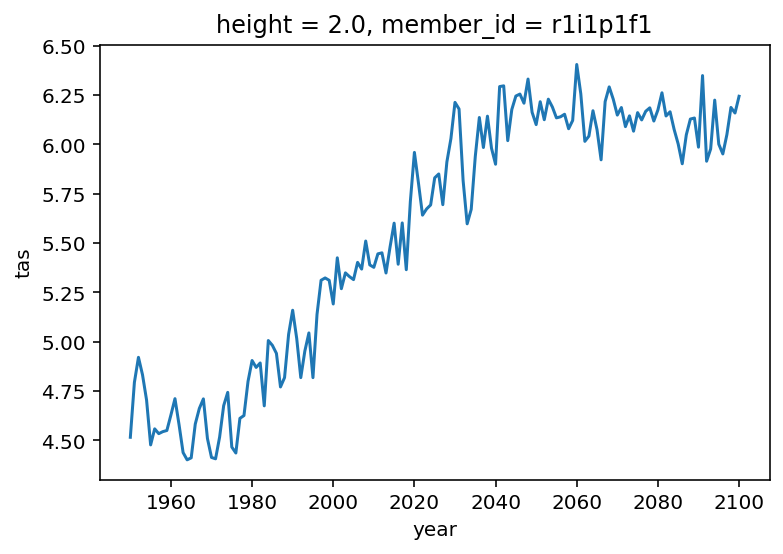

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
(mpi_esm_mean_.sel(year=slice(1950, 2100)) - 273.5).plot()

So we could actually plot scenario time series data of MPI-ESM data without any preprocessing or merging simply from the original data. We don't even care where the data comes from, in which format it is stored or of how many files it consists on the filesystem. Actually, the data doesn't even have to be located on our filesystem but could also come from a cloud source.

But wait! That temperature seems low, doesn't it? That's because we forgot to [weight](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) the spatial mean with the area of the grid cell. And because grid cells at the pole are much smaller than at the equator, they have unsually large impact on the global mean. Let's quickly correct this:

In [20]:
weight = np.cos(np.deg2rad(mpi_esm.lat))
weight /= weight.mean()
mpi_esm_temporal_mean = mpi_esm.tas.groupby("time.year").mean(dim=("time"))
mpi_esm_weighted_mean = (mpi_esm_temporal_mean * weight).mean(dim=("lat", "lon"))

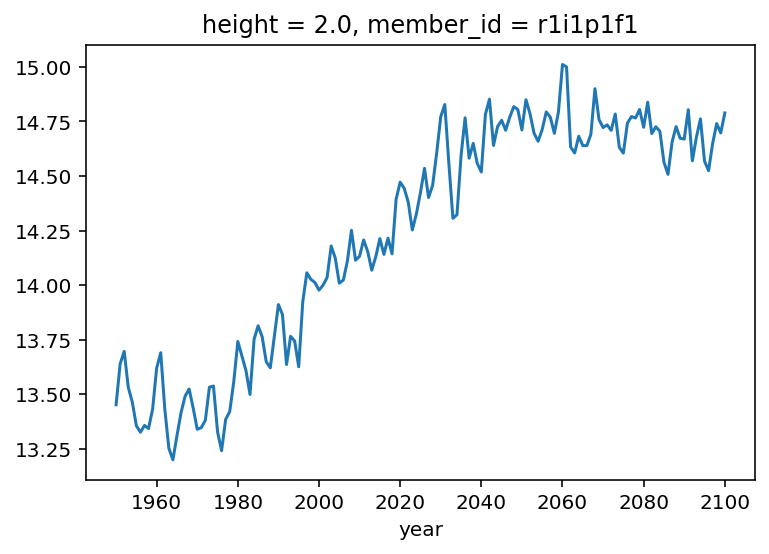

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
(mpi_esm_weighted_mean.sel(year=slice(1950, 2100)) - 273.5).plot()

Better!

## Create an ensemble dataset

Ok, now that we know how to process single datasets, we can easily extend this to all datasets in our dataset dictionary. We create some helper functions for this (also for handling inconsistencies in the CMIP6 conventions):

In [24]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds if (("bounds") in vname) or ("bnds") in vname]
    return ds.drop(drop_vars)


def get_lat_name(ds):
    for lat_name in ["lat", "latitude"]:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def global_mean(ds):
    """weighted spatial global mean"""
    ds = drop_all_bounds(ds)
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    return (ds * weight).mean(dim=("lon", "lat"))

... and we also reorganize our data a little bit for easier access so that we can easily loop through all models and scenarios...

In [25]:
from collections import defaultdict

dsets_dict = defaultdict(dict)

from tqdm.autonotebook import tqdm

for key, ds in tqdm(dsets.items()):
    attrs = key.split(".")
    source_id = attrs[2]
    experiment_id = attrs[3]
    print(key)
    dsets_dict[source_id][
        experiment_id
    ] = ds  # .tas.groupby('time.year').mean() #.mean(dim=('lat', 'lon'))

  0%|          | 0/120 [00:00<?, ?it/s]

ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.Amon.gn
ScenarioMIP.INM.INM-CM4-8.ssp126.Amon.gr1
ScenarioMIP.NUIST.NESM3.ssp126.Amon.gn
ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.ssp585.Amon.gr1
ScenarioMIP.CMCC.CMCC-ESM2.ssp585.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.ssp126.Amon.gr1
CMIP.CMCC.CMCC-ESM2.historical.Amon.gn
ScenarioMIP.CMCC.CMCC-ESM2.ssp245.Amon.gn
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp585.Amon.gr
ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn
ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn
ScenarioMIP.FIO-QLNM.FIO-ESM-2-0.ssp126.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp245.Amon.gr1
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp126.Amon.gr
ScenarioMIP.CAS.FGOALS-f3-L.ssp245.Amon.gr
ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp245.Amon.gn
ScenarioMIP.AS-RCEC.TaiESM1.ssp126.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.KIOST.KIOST-ESM.historical.Amon.gr1
ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp126.Amon.gn
ScenarioMIP.CAMS.C

Unfortunately, there is always an issue with the timelines from the different models, e.g., CIESM uses a normal gregorian calendar...

In [26]:
dsets_dict["MPI-ESM1-2-HR"]["historical"].time

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeProlepticGregorian(2014, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2014, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2014, 12, 16, 12, 0, 0, 0)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    height   float64 ...
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

while, e.g, `GFDL` uses a Calendat that ignores leap year, e.g.

In [27]:
dsets_dict["GFDL-ESM4"]["ssp245"].time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
    height   float64 ...
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  noleap
    bounds:         time_bnds
    standard_name:  time
    description:    Temporal mean

This will get us in trouble, when we want to create an ensemble dataset because, by default, it's not clear how to align these calendars. But because we only have monthly means anyway, we can just ignore this and actually just hack in a common calendar for all datasets (we will set the data always to the 15th of the month). Furthermore we will compute the global weighted spatial mean for all models and scenarios. We also use a little trick where we will align all scenarios and the historical time series for each model into a single dataset where the scenario actually becomes not a key in the dictionary but a dataset coordinate! This will become clear in a minute:

In [30]:
from cftime import datetime as dt

expt_da = xr.DataArray(
    expts, dims="experiment_id", name="experiment_id", coords={"experiment_id": expts}
)

dsets_aligned = {}

for k, v in tqdm(dsets_dict.items()):
    print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords["time"] = [dt(date.year, date.month, 15) for date in ds.time.values]
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_global_mean = [v[expt].pipe(global_mean) for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_global_mean, join="outer", dim=expt_da)

  0%|          | 0/30 [00:00<?, ?it/s]

ACCESS-CM2
INM-CM4-8
NESM3
ACCESS-ESM1-5
KIOST-ESM
CMCC-ESM2
KACE-1-0-G
CanESM5
FIO-ESM-2-0
GFDL-ESM4
FGOALS-f3-L
TaiESM1
CAMS-CSM1-0
CIESM
IPSL-CM6A-LR
BCC-CSM2-MR
INM-CM5-0
MIROC6
CMCC-CM2-SR5
MPI-ESM1-2-LR
MRI-ESM2-0
FGOALS-g3
NorESM2-LM
IITM-ESM
NorESM2-MM
MPI-ESM1-2-HR
EC-Earth3-Veg
EC-Earth3
AWI-CM-1-1-MR
EC-Earth3-Veg-LR


Now, the resulting dictionary only has one key left for the source id (or the model) while the scenario is now a dataset coordinate. Let's have a look at `MPI-ESM1-2-LR` as an example to understand the advantage of this:

In [31]:
dsets_aligned["MPI-ESM1-2-LR"]

<xarray.Dataset>
Dimensions:        (experiment_id: 4, member_id: 1, time: 3012)
Coordinates:
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * time           (time) object 1850-01-15 00:00:00 ... 2100-12-15 00:00:00
    height         float64 2.0
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    tas            (experiment_id, member_id, time) float64 dask.array<chunksize=(1, 1, 240), meta=np.ndarray>

You can see that we, in fact, reduced the spatial dimensions (lat, lon) by the spatial mean and only have a time series of monthly data left. Furthemore, we aligned the historical and scenario datasets into one dataset with an `experiment_id` coordinate. This will make the further processing and plotting much easier because we can refer to the experiment like any other xarray coordinate ([labeled data](http://xarray.pydata.org/en/stable/why-xarray.html)). Note, that we didn't actually concatenate any files, etc. This dataset exists actually only virtually in the memory. Remember that we didn't actually trigger the computation yet, but we will do this now using dask:

In [32]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

That's it. Let's check the resulting keys in the dictionary:

In [33]:
dsets_aligned_.keys()

dict_keys(['ACCESS-CM2', 'INM-CM4-8', 'NESM3', 'ACCESS-ESM1-5', 'KIOST-ESM', 'CMCC-ESM2', 'KACE-1-0-G', 'CanESM5', 'FIO-ESM-2-0', 'GFDL-ESM4', 'FGOALS-f3-L', 'TaiESM1', 'CAMS-CSM1-0', 'CIESM', 'IPSL-CM6A-LR', 'BCC-CSM2-MR', 'INM-CM5-0', 'MIROC6', 'CMCC-CM2-SR5', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'FGOALS-g3', 'NorESM2-LM', 'IITM-ESM', 'NorESM2-MM', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'EC-Earth3', 'AWI-CM-1-1-MR', 'EC-Earth3-Veg-LR'])

Now, we can make one furter last step in defining our ensemble data. We will do the same trick again and also make the model id a coordinate by concatenating all datasets. Since we only have time series data (without any spatial dimension) and because we fixed the different calendars, we can do this very easily:

In [34]:
# define the model coordinate
models = list(dsets_aligned_.keys())
model_da = xr.DataArray(models, dims="model", name="model", coords={"model": models})

# concatenate all datasets from the dictionary
ensemble_ds = xr.concat(
    [ds.reset_coords(drop=True) for ds in dsets_aligned_.values()], dim=model_da
)
ensemble_ds

<xarray.Dataset>
Dimensions:        (bnds: 2, experiment_id: 4, member_id: 1, model: 30, time: 5412)
Coordinates:
  * model          (model) <U16 'ACCESS-CM2' 'INM-CM4-8' ... 'EC-Earth3-Veg-LR'
  * bnds           (bnds) float64 1.0 2.0
  * time           (time) object 1850-01-15 00:00:00 ... 2300-12-15 00:00:00
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    tas            (model, experiment_id, member_id, time) float64 285.2 ... nan

Ok, we are done. We have now our complete ensemble data in one virtual four dimensional dataset (`model`, `experiment_id`, `member_id`, `time`). 

## Plotting

The virtual dataset will make the rest of our analysis really easy and straight forward. For example, let's plot annual means for **all** datasets:

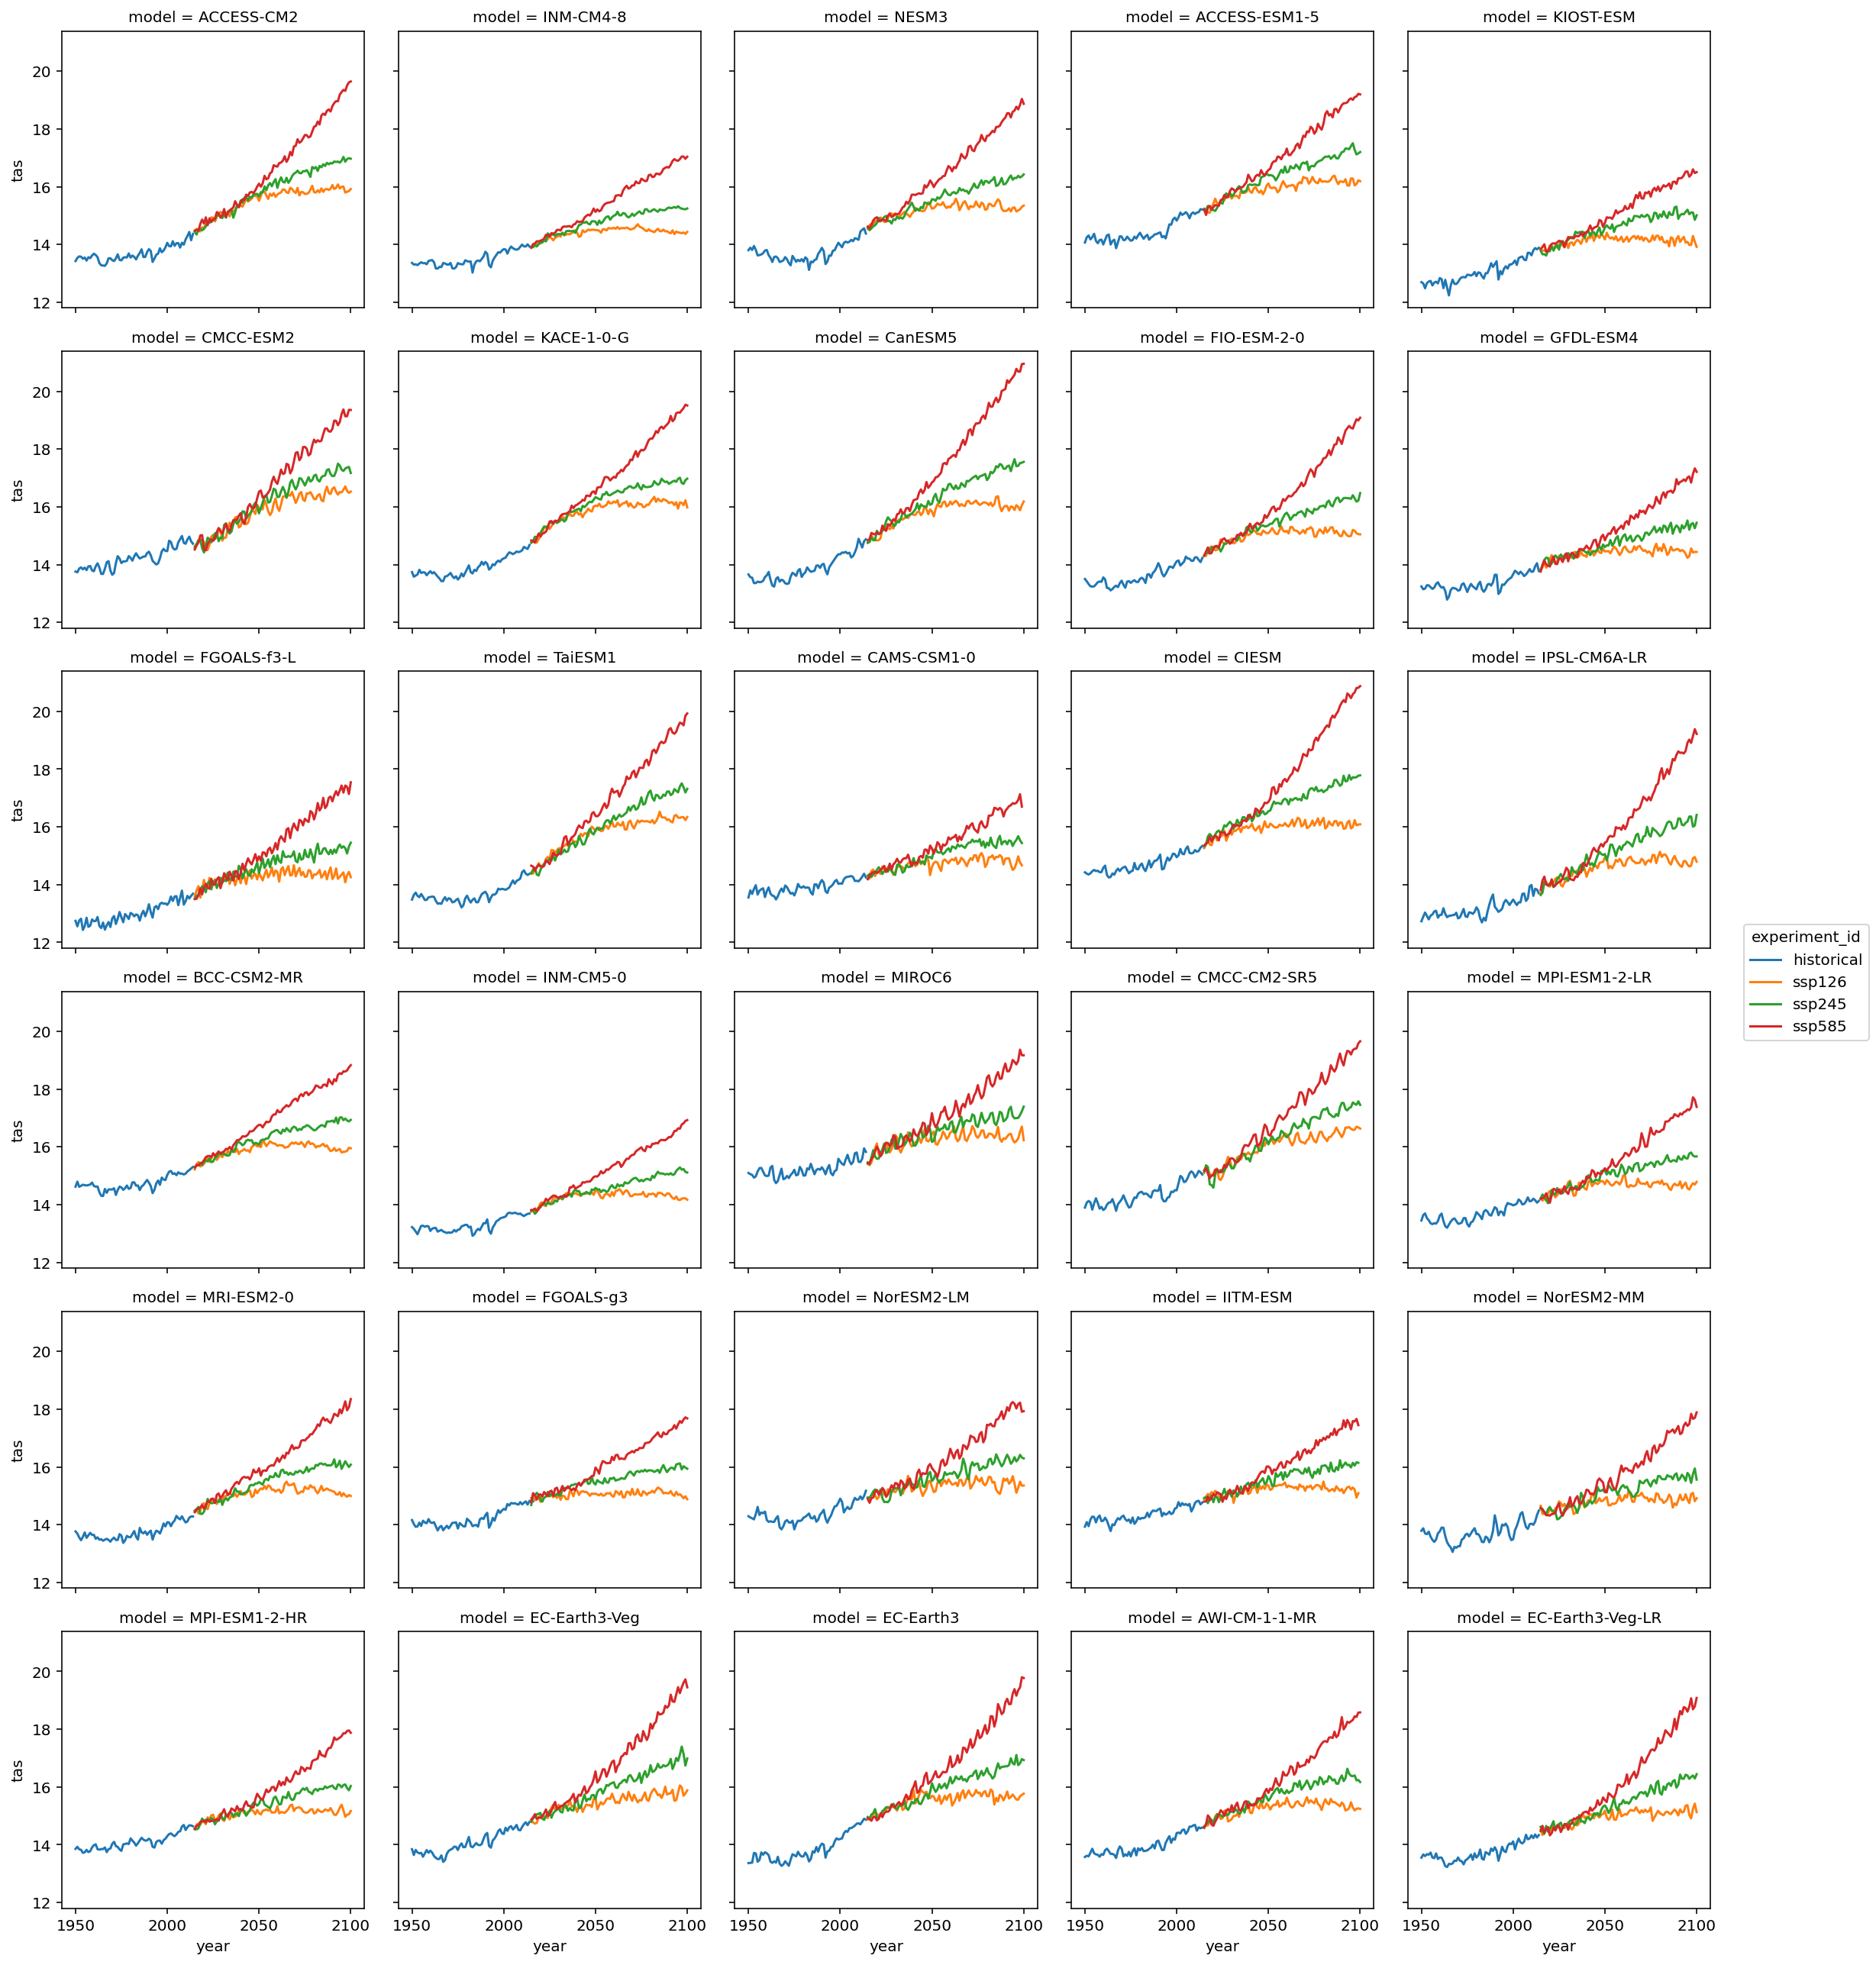

In [37]:
# compute the annual mean
annual_mean = ensemble_ds.groupby("time.year").mean()
# create a line plot for each model id!
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# annual_mean.drop('member_id')
(annual_mean.tas.sel(year=slice(1950, 2100)) - 273.5).plot(
    col="model", x="year", hue="experiment_id", col_wrap=5
)

You can see that we now can use the additional coordinates to easily plot the data in different formats.

## Bonus step: get into pandas...

Because we have reduced our data to a number of time series, it's ideal to use pandas for further analysis. xarray has a nice feature for this which will convert your dataset or dataarray into a pandas dataframe:

In [38]:
df_all = annual_mean.sel(year=slice(1950, 2100)).to_dataframe().reset_index()
df_all.head()

,bnds,experiment_id,member_id,model,year,tas
0,1.0,historical,r1i1p1f1,ACCESS-CM2,1950,286.927087
1,1.0,historical,r1i1p1f1,ACCESS-CM2,1951,287.034626
2,1.0,historical,r1i1p1f1,ACCESS-CM2,1952,287.088474
3,1.0,historical,r1i1p1f1,ACCESS-CM2,1953,287.079060
4,1.0,historical,r1i1p1f1,ACCESS-CM2,1954,287.007894


Now, we can use, e.g., seaborn to make a nice ensemble plot. Here we make a plot showing the 95th percentile of all models.

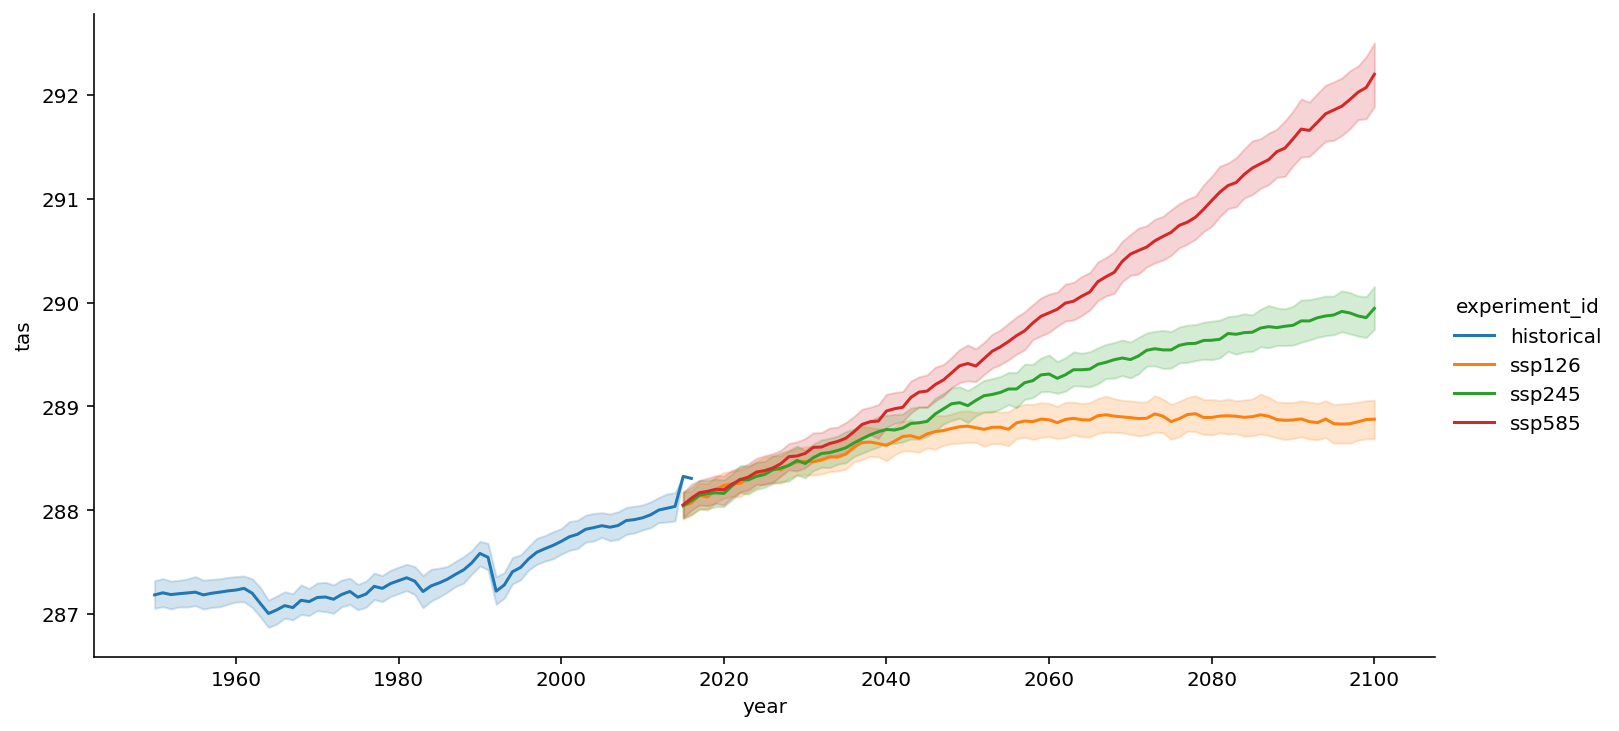

In [39]:
sns.relplot(
    data=df_all, x="year", y="tas", hue="experiment_id", kind="line", ci=95, aspect=2
);

In [40]:
df_all.to_csv("cmip6_global_mean.csv")

Don't forget to shutdown your dask client to save computational cost!

In [41]:
# client.shutdown()